Code Attribution Statement

This assignment implements object detection models based on the PyTorch official
tutorial "TorchVision Object Detection Finetuning Tutorial" available at:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

AI assistance from ChatGPT was used for:
- Code debugging and error resolution
- Implementation guidance for Option 2 (MobileNetV2 backbone)
- Explanation of model architecture concepts

In [1]:
!pip install pycocotools -q

import os
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import v2 as T
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget -q https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

import utils
from engine import train_one_epoch, evaluate

# Prepare the Dataset

In [2]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip -q PennFudanPed.zip

# Define dataset
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)

        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

--2025-11-24 03:16:10--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  59.6MB/s    in 0.9s    

2025-11-24 03:16:11 (59.6 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]



# Define the Model

In [3]:
# Option 1: Pretrained Mask R-CNN (ResNet50-FPN backbone)
def get_model_option1(num_classes):
    """Option 1 from the tutorial - Fine-tune a pretrained model"""
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # Replace the box predictor
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return model

# Option 2: Custom backbone (MobileNetV2)
def get_model_option2(num_classes):
    """Option 2 - Use MobileNetV2 as the backbone"""
    # Load MobileNetV2 backbone
    backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
    backbone.out_channels = 1280

    # Define anchor generator
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),),
        aspect_ratios=((0.5, 1.0, 2.0),)
    )

    # Define ROI pooler (for boxes)
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )

    # Define mask ROI pooler
    mask_roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=14,
        sampling_ratio=2
    )

    # Create the Mask R-CNN model
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        mask_roi_pool=mask_roi_pooler
    )

    return model


# Train the model

In [4]:
"""Train the model and return training history"""

def train_model(model, model_name, num_epochs=10):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"\nTraining {model_name} on {device}")

    # Prepare datasets
    dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
    dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

    # Split datasets
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # Data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
    )
    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn
    )

    # Move model to device
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Training loop
    training_history = []

    for epoch in range(num_epochs):
        # Train for one epoch
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        lr_scheduler.step()

        # Evaluate on the test set
        coco_evaluator = evaluate(model, data_loader_test, device=device)

        # Save metrics
        stats = coco_evaluator.coco_eval['bbox'].stats
        mask_stats = coco_evaluator.coco_eval['segm'].stats
        training_history.append({
            'epoch': epoch,
            'bbox_mAP': stats[0],
            'bbox_mAP_50': stats[1],
            'mask_mAP': mask_stats[0],
            'mask_mAP_50': mask_stats[1],
        })

        print(f"\n[Epoch {epoch}] bbox mAP: {stats[0]:.4f}, mask mAP: {mask_stats[0]:.4f}")

    return model, training_history


# Run the train


------------------------------------------------------------
Train Option 1: ResNet50-FPN Backbone
------------------------------------------------------------
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:00<00:00, 202MB/s]



Training Option1_ResNet50 on cuda


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:02:33  lr: 0.000090  loss: 3.4514 (3.4514)  loss_classifier: 1.0042 (1.0042)  loss_box_reg: 0.3010 (0.3010)  loss_mask: 2.1363 (2.1363)  loss_objectness: 0.0077 (0.0077)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 2.5663  data: 0.0739  max mem: 2306
Epoch: [0]  [10/60]  eta: 0:00:20  lr: 0.000936  loss: 1.7222 (2.2860)  loss_classifier: 0.6110 (0.5954)  loss_box_reg: 0.2843 (0.2898)  loss_mask: 0.8940 (1.3610)  loss_objectness: 0.0307 (0.0341)  loss_rpn_box_reg: 0.0035 (0.0057)  time: 0.4157  data: 0.0263  max mem: 2539
Epoch: [0]  [20/60]  eta: 0:00:11  lr: 0.001783  loss: 1.2184 (1.6333)  loss_classifier: 0.2701 (0.4274)  loss_box_reg: 0.2843 (0.3135)  loss_mask: 0.4541 (0.8548)  loss_objectness: 0.0307 (0.0302)  loss_rpn_box_reg: 0.0055 (0.0074)  time: 0.1801  data: 0.0226  max mem: 2539
Epoch: [0]  [30/60]  eta: 0:00:07  lr: 0.002629  loss: 0.7194 (1.2812)  loss_classifier: 0.1485 (0.3155)  loss_box_reg: 0.2747 (0.2871)  loss_mask: 0.2376 (0.6485)  loss_ob

100%|██████████| 13.6M/13.6M [00:00<00:00, 53.8MB/s]



Training Option2_MobileNetV2 on cuda
Epoch: [0]  [ 0/60]  eta: 0:00:17  lr: 0.000090  loss: 4.9445 (4.9445)  loss_classifier: 0.7381 (0.7381)  loss_box_reg: 0.0677 (0.0677)  loss_mask: 3.4001 (3.4001)  loss_objectness: 0.6923 (0.6923)  loss_rpn_box_reg: 0.0463 (0.0463)  time: 0.2941  data: 0.0128  max mem: 3957
Epoch: [0]  [10/60]  eta: 0:00:08  lr: 0.000936  loss: 3.9670 (4.1110)  loss_classifier: 0.6821 (0.6499)  loss_box_reg: 0.0593 (0.0609)  loss_mask: 2.6477 (2.6699)  loss_objectness: 0.6765 (0.6755)  loss_rpn_box_reg: 0.0463 (0.0548)  time: 0.1743  data: 0.0199  max mem: 6077
Epoch: [0]  [20/60]  eta: 0:00:06  lr: 0.001783  loss: 2.8572 (3.1872)  loss_classifier: 0.4224 (0.4840)  loss_box_reg: 0.0687 (0.0872)  loss_mask: 1.5924 (1.9322)  loss_objectness: 0.6478 (0.6380)  loss_rpn_box_reg: 0.0310 (0.0458)  time: 0.1569  data: 0.0204  max mem: 6077
Epoch: [0]  [30/60]  eta: 0:00:04  lr: 0.002629  loss: 1.7552 (2.6979)  loss_classifier: 0.2615 (0.4187)  loss_box_reg: 0.1260 (0.1127

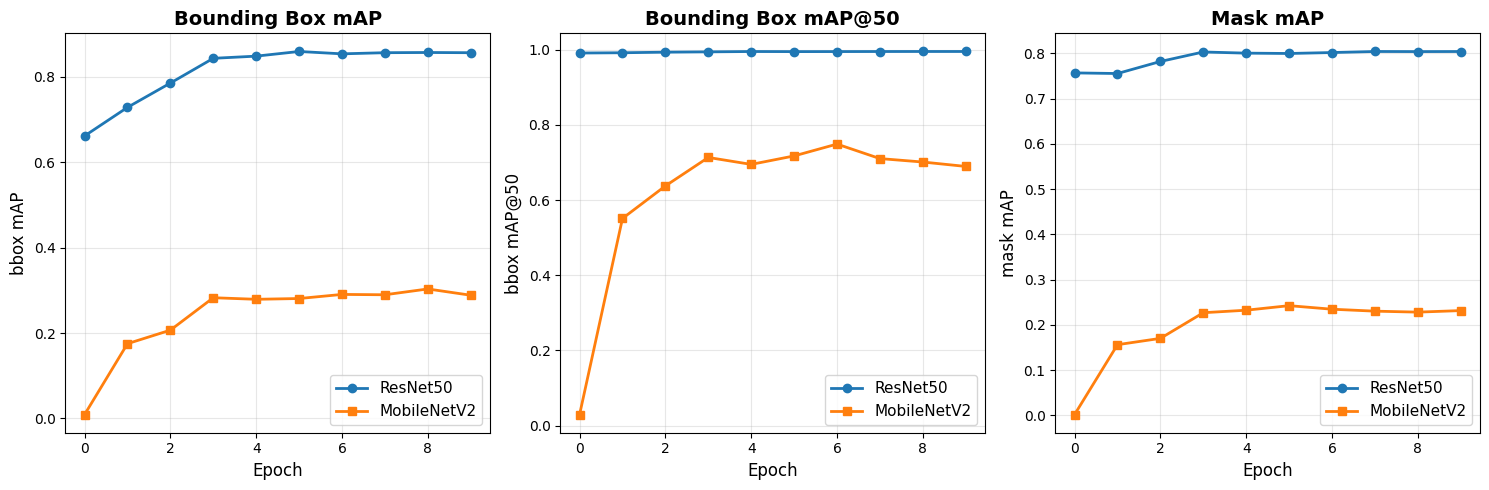

In [6]:
num_classes = 2  # person + background

# Train Option 1
print("\n" + "-"*60)
print("Train Option 1: ResNet50-FPN Backbone")
print("-"*60)
model1 = get_model_option1(num_classes)
model1_trained, history1 = train_model(model1, "Option1_ResNet50", num_epochs=10)

# Train Option 2
print("\n" + "-"*60)
print("Train Option 2: MobileNetV2 Backbone")
print("-"*60)
model2 = get_model_option2(num_classes)
model2_trained, history2 = train_model(model2, "Option2_MobileNetV2", num_epochs=10)

# Performance compare
print("\n" + "-"*60)
print("Part (b): Performance compare (after 10 epochs)")
print("-"*60)
print(f"\nOption 1 (ResNet50-FPN):")
print(f"  Final bbox mAP: {history1[-1]['bbox_mAP']:.4f}")
print(f"  Final bbox mAP@50: {history1[-1]['bbox_mAP_50']:.4f}")
print(f"  Final mask mAP: {history1[-1]['mask_mAP']:.4f}")

print(f"\nOption 2 (MobileNetV2):")
print(f"  Final bbox mAP: {history2[-1]['bbox_mAP']:.4f}")
print(f"  Final bbox mAP@50: {history2[-1]['bbox_mAP_50']:.4f}")
print(f"  Final mask mAP: {history2[-1]['mask_mAP']:.4f}")

# plot the train
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot([h['epoch'] for h in history1], [h['bbox_mAP'] for h in history1],
         'o-', label='ResNet50', linewidth=2, markersize=6)
plt.plot([h['epoch'] for h in history2], [h['bbox_mAP'] for h in history2],
         's-', label='MobileNetV2', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('bbox mAP', fontsize=12)
plt.title('Bounding Box mAP', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot([h['epoch'] for h in history1], [h['bbox_mAP_50'] for h in history1],
         'o-', label='ResNet50', linewidth=2, markersize=6)
plt.plot([h['epoch'] for h in history2], [h['bbox_mAP_50'] for h in history2],
         's-', label='MobileNetV2', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('bbox mAP@50', fontsize=12)
plt.title('Bounding Box mAP@50', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot([h['epoch'] for h in history1], [h['mask_mAP'] for h in history1],
         'o-', label='ResNet50', linewidth=2, markersize=6)
plt.plot([h['epoch'] for h in history2], [h['mask_mAP'] for h in history2],
         's-', label='MobileNetV2', linewidth=2, markersize=6)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('mask mAP', fontsize=12)
plt.title('Mask mAP', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Test on photo

--2025-11-24 03:21:45--  https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159905 (156K) [image/jpeg]
Saving to: ‘beatles.jpg’

beatles.jpg         100%[===================>] 156.16K  --.-KB/s    in 0.08s   

2025-11-24 03:21:45 (1.93 MB/s) - ‘beatles.jpg’ saved [159905/159905]


------------------------------------------------------------
Part (c): Test on Beatles image
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torchvision/utils.py:375: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


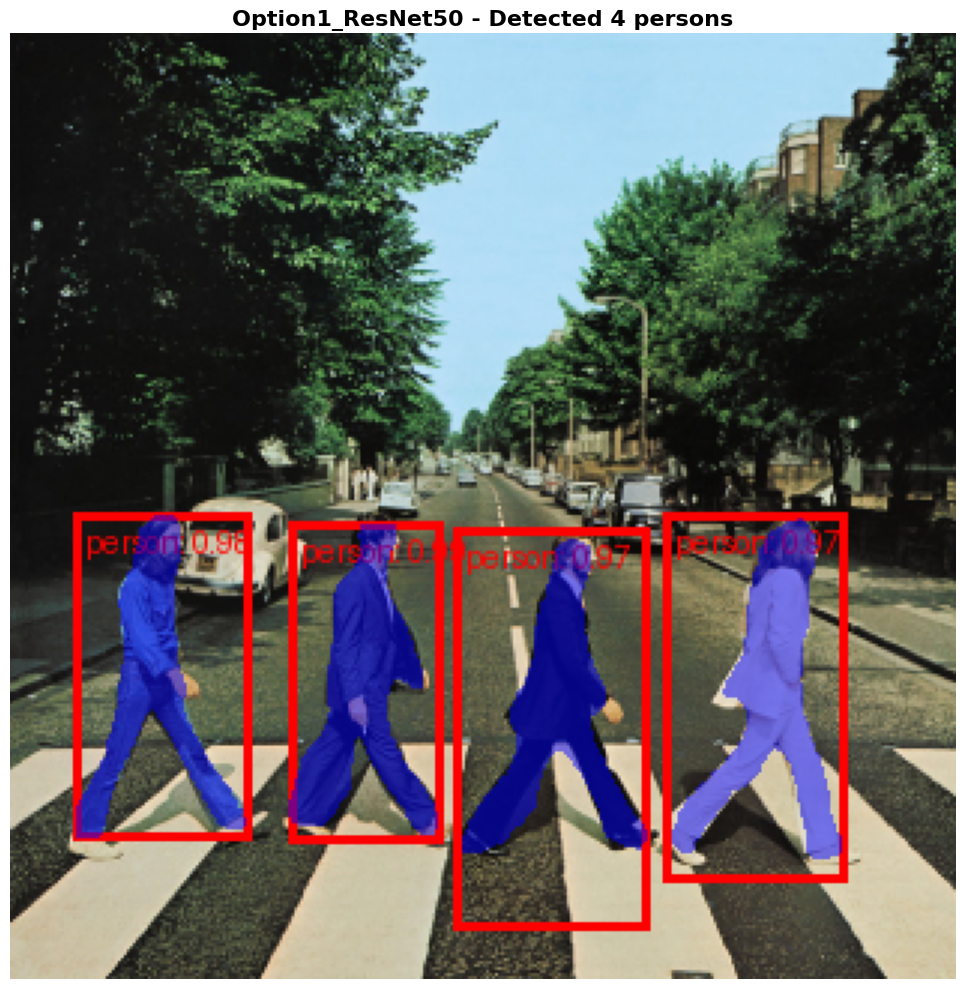


Option 1 detected 4 persons
Average confidence: 0.977


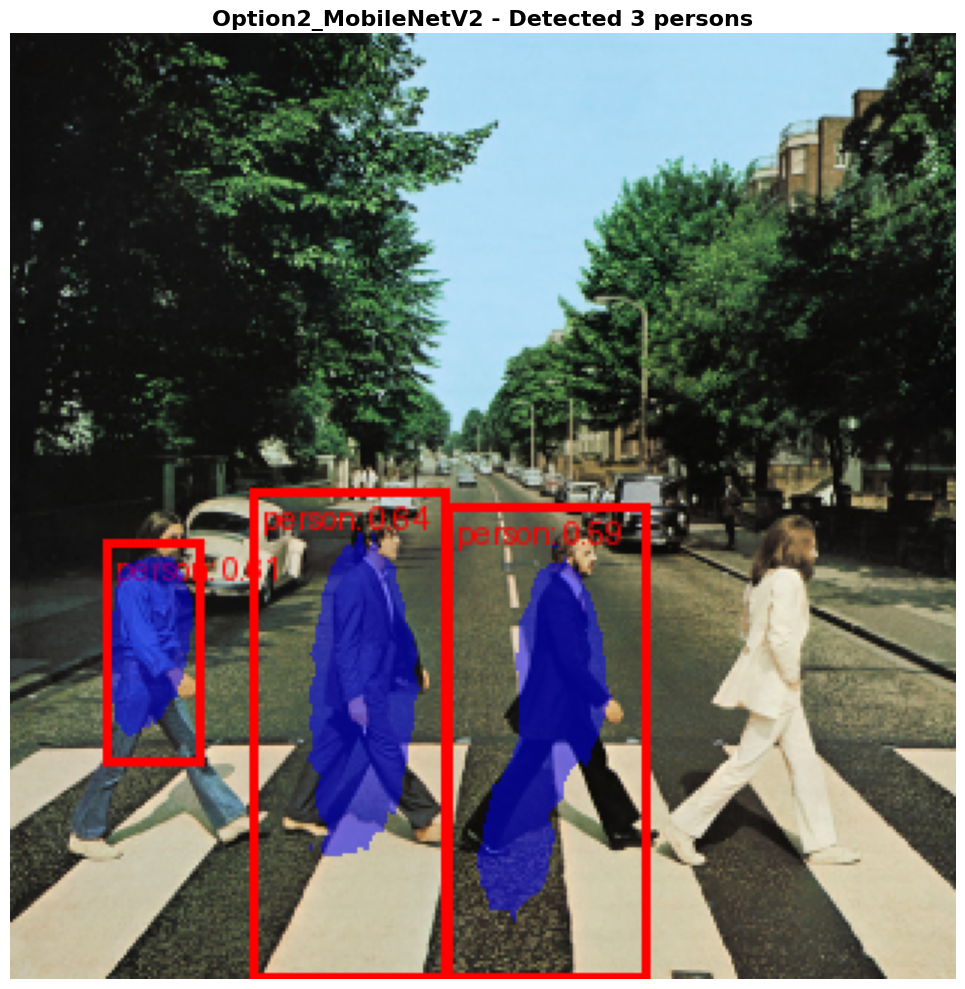


Option 2 detected 3 persons
Average confidence: 0.612

------------------------------------------------------------
Comparison of Beatles image detection results
------------------------------------------------------------
Option 1 (ResNet50): 4 persons, Average confidence 0.977
Option 2 (MobileNetV2): 3 persons, Average confidence 0.612


In [7]:
!wget https://upload.wikimedia.org/wikipedia/en/4/42/Beatles_-_Abbey_Road.jpg -O beatles.jpg

def test_on_image(model, model_name, image_path, threshold=0.5):
    """Test the model on a specified image"""
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()

    # Load and preprocess the image
    image = read_image(image_path)
    eval_transform = get_transform(train=False)

    with torch.no_grad():
        x = eval_transform(image)
        # Ensure RGB (first 3 channels)
        x = x[:3, ...].to(device)
        predictions = model([x])[0]

    # Visualization
    image = image[:3, ...]
    # Normalize to 0-255
    image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)

    # Filter out low-confidence predictions
    keep = predictions["scores"] > threshold

    pred_boxes = predictions["boxes"][keep].long().cpu()
    pred_scores = predictions["scores"][keep].cpu()
    pred_labels = [f"person: {score:.2f}" for score in pred_scores]
    pred_masks = (predictions["masks"][keep] > 0.7).squeeze(1).cpu()

    # Draw results
    output_image = draw_bounding_boxes(image, pred_boxes, pred_labels,
                                       colors="red", width=3, font_size=20)
    if len(pred_masks) > 0:
        output_image = draw_segmentation_masks(output_image, pred_masks,
                                               alpha=0.5, colors="blue")

    plt.figure(figsize=(14, 10))
    plt.imshow(output_image.permute(1, 2, 0))
    plt.title(f"{model_name} - Detected {len(pred_boxes)} persons",
              fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{model_name}_beatles_result.png', dpi=150, bbox_inches='tight')
    plt.show()

    return len(pred_boxes), pred_scores

# Test the two models
beatles_image_path = "beatles.jpg"  # Make sure this file exists

print("\n" + "-"*60)
print("Part (c): Test on Beatles image")
print("-"*60)

if os.path.exists(beatles_image_path):
    # Test Option 1
    count1, scores1 = test_on_image(model1_trained, "Option1_ResNet50",
                                     beatles_image_path, threshold=0.5)
    print(f"\nOption 1 detected {count1} persons")
    print(f"Average confidence: {scores1.mean():.3f}")

    # Test Option 2
    count2, scores2 = test_on_image(model2_trained, "Option2_MobileNetV2",
                                     beatles_image_path, threshold=0.5)
    print(f"\nOption 2 detected {count2} persons")
    print(f"Average confidence: {scores2.mean():.3f}")

    # Compare
    print("\n" + "-"*60)
    print("Comparison of Beatles image detection results")
    print("-"*60)
    print(f"Option 1 (ResNet50): {count1} persons, Average confidence {scores1.mean():.3f}")
    print(f"Option 2 (MobileNetV2): {count2} persons, Average confidence {scores2.mean():.3f}")
else:
    print(f"\nPlease download the Beatles image and save it as '{beatles_image_path}'")


prob4(b)

> ResNet50-FPN achieves much better performance, with a bounding box mAP of 88.69% and mask mAP of 80.43%, whereas MobileNetV2 only reaches 28.86% and 23.18%, respectively.


prob4(c)


> ResNet50 correctly detected all 4 people with a high average confidence of 0.977, while MobileNetV2 detected only 3 people with a lower average confidence of 0.612. This shows that ResNet50 has stronger generalization ability and higher detection accuracy on real-world images outside the training distribution. The results indicate that ResNet50-FPN is more reliable for pedestrian detection, whereas MobileNetV2 provides faster inference but at the cost of missing some detections.


